In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import fnmatch
import numpy as np
import os
from surgeNN.io import load_predictand,load_predictors
from surgeNN.preprocessing import get_denseloss_weights,get_splitted_predictand_and_predictor_data,get_splitted_predictand_and_predictor_data_stratified_on_amax,stack_predictors_for_lstm, normalize_predictand_splits, normalize_predictor_splits,standardize_predictand_splits, standardize_predictor_splits
from surgeNN.models import build_LSTM_stacked
from surgeNN.models import build_LSTM_stacked
from surgeNN.losses import gevl,mse_exp_negexp
from surgeNN.utils import create_batched_sequenced_datasets, compute_statistics_for_output_ds, generate_windowed_finite_numpy_input,rmse
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from target_relevance import TargetRelevance #if starting with a clean environment, first, in terminal, do->'mamba install kdepy'

import gc #callback to clean up garbage after each epoch, not sure if needed (usage: callbacks = [GC_Callback()])
class GC_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

2024-07-25 19:01:16.293702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Configure the script:

In [59]:
tgs        = ['barcelona-bar-esp-cmems.csv','den_helder-denhdr-nld-rws.csv', 'brest-822a-fra-uhslc.csv', 
            'immingham-imm-gbr-bodc.csv','stavanger-svg-nor-nhs.csv'] #tide gauges to process
tgs = ['den_helder-denhdr-nld-rws.csv']
temp_freq = 6 # [hours] temporal frequency to use
n_cells   = 5 #n x n grid cells around tide gauge of predictor data to use

var_names = ['msl','u10','v10','w'] #variables to use
loss_function = 'DenseLoss_mse' # any default loss function or 'DenseLoss_[default loss function]' or 'gevl'
alpha = 4 #DenseLoss alpha parameter, vary between 1-5? (not used if not using loss function)
gamma = 3 #gevl gamma parameter, vary between 1-3? (not used if not using loss function)
a = .5
t = 1

input_dir  = '/home/jovyan/test_surge_models/input/' #directory with predictor & predictand data
output_dir = '/home/jovyan/test_surge_models/results/lstm_loss_function_tests/' #where to store the results

n_runs = 1 #how many iterations with different hyperparameter combinations to run
n_epochs = 75 #how many training epochs
patience = 5 #early stopping patience
split_fractions = [.5,.25,.25] #train, test, val

#hyperparameters:
batch_size = np.array([128]).astype('int')
n_steps = np.array([5]).astype('int') #at and 12h or 24h or 36h before (to-do: also use timesteps after?)
n_lstm = np.array([2]).astype('int')
n_lstm_units = np.array([48]).astype('int')
n_dense = np.array([2]).astype('int')
n_dense_units = np.array([48]).astype('int')
dropout = np.array([0.1])
lrs = np.array([1e-5])
l1s = np.array([0.02])

possible_params = [batch_size, n_steps, n_lstm, n_lstm_units,
                    n_dense, n_dense_units, dropout, lrs, l1s]

n_combinations = np.prod(np.array([len(k) for k in possible_params])) #number of unique combinations possible

Determine loss function to use:

In [60]:
#determine loss function to use
use_dl = False
dl_pos_only = False

if loss_function.split('_')[0] == 'DenseLoss':
    use_dl = True
    dl_pos_only = False
    loss_function_ = loss_function.split('_')[-1]
                                
elif loss_function.split('_')[0] == 'DenseLossPos':
    use_dl = True
    dl_pos_only = True
    loss_function_ = loss_function.split('_')[-1]  
    
elif loss_function == 'gevl':
    loss_function_ = gevl(gamma)
    #use_dl=True

elif loss_function =='mse_exp':
    loss_function_ = mse_exp_negexp(a,t)
else:
    loss_function_ = loss_function

Load in & preprocess data:

In [69]:
tg_lons = []
tg_lats = []

for tg in tqdm(tgs): #loop over TGs
    for alpha in np.array([10]):
       
        
        tf.keras.backend.clear_session() #clean up previous training session

        #load & process predictors
        predictors = load_predictors('/home/jovyan/test_surge_models/input/predictors_'+str(temp_freq)+'hourly',tg,n_cells) #open predictor xarray dataset
        predictors = predictors.sel(time=slice('1980','2017')) #2018 because of end year GTSM simulations that are used as benchmark

        #load & process predictands
        predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands',tg) #open predictand csv
        predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)]  # only use predictands in the period for which we also have predictor values, including at preceding timesteps
        
        predictand = predictand.set_index('date').resample(str(temp_freq)+'h').fillna(method=None) #insert nans where timesteps are missing
        predictand = predictand.reset_index()[['surge','date','lon','lat']]

        predictand['surge'] = predictand['surge'].rolling(window=int(12/temp_freq+1),min_periods=int(12/temp_freq+1),center=True).mean() #crude way to filter out peaks due to uncorrected tides (Tiggeloven et al., 2021)
        
        #test ### if splitting stratifying years
        predictand['surge'].iloc[np.where([((m == 7) & (d<3)) for m,d in zip(predictand.date.dt.month,predictand.date.dt.day)])] = np.nan
        #########
        
        #pre-generate input data for each n_steps (on which the input data depends)
        input_dict = {}
        for n in n_steps:

            #generate splits
            #idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test = get_splitted_predictand_and_predictor_data(predictand,predictors,split_fractions,n)
            idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test = get_splitted_predictand_and_predictor_data_stratified_on_amax(predictand,predictors,split_fractions,n,7,seed=0)
            #idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test,y_train_mean,y_train_std = get_predictand_and_predictor_splits(predictand,predictors,split_ratios,n,var_names)

            #standardize the input based on the mean & sd of the train split
            y_train,y_val,y_test,y_train_mean,y_train_sd = standardize_predictand_splits(y_train,y_val,y_test,output_transform = True)
            x_train,x_val,x_test = standardize_predictor_splits(x_train,x_val,x_test)
            '''
            y_train,y_val,y_test,y_train_mean,y_train_sd = normalize_predictand_splits(y_train,y_val,y_test,output_transform = True)
            x_train,x_val,x_test = normalize_predictor_splits(x_train,x_val,x_test)
            '''

            x_train, x_val, x_test = [stack_predictors_for_lstm(k,var_names) for k in [x_train,x_val,x_test]] #stack all predictor variables at each grid cell for LSTM input
            w_train,w_val = [get_denseloss_weights(k, alpha = alpha ) for k in [y_train,y_val]] #generate DenseLoss weights for train & val splits                             

            #put all input into a dictionary to access later
            input_dict[n] = [idx_train,idx_val,idx_test, x_train,x_val,x_test,
                             y_train,y_val,y_test, y_train_mean,y_train_sd,
                             w_train,w_val]

        #train & evaluate models n_runs times:
        all_params = [] #list of hyperparameters
        tg_datasets = [] #list to store output

        for i in tqdm(np.arange(n_runs if n_runs < n_combinations else n_combinations)): #loop over hyperparameter combinations

            #randomly select unique combinations of hyperparameters
            k=True 
            while k == True:
                these_params = [np.random.choice(k) for k in possible_params] 
                if these_params in all_params:
                    k = True
                else:
                    k = False
                    all_params.append(these_params) #keep track of hyperparameter combinations

            this_batch_size,this_n_steps,this_n_lstm,this_n_lstm_units,this_n_dense,this_n_dense_units,this_dropout,this_lr,this_l2 = these_params

            #load data for this tide gauge and n_steps
            idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test,y_train_mean,y_train_sd,w_train,w_val = input_dict[this_n_steps] #fetch input data for this_n_steps

            #get values & timestamps of observations to compare predictions with
            t_train = predictand['date'].values[idx_train][np.isfinite(y_train)]
            t_val = predictand['date'].values[idx_val][np.isfinite(y_val)]
            t_test = predictand['date'].values[idx_test][np.isfinite(y_test)]

            #get windowed predictors & filter rows with nan observations from inputs (for tensorflow pipeline (to handle out-of-memory windowed predictors) see code below)
            x_train,y_train,w_train = generate_windowed_finite_numpy_input(x_train,y_train,this_n_steps,w_train)
            x_val,y_val,w_val = generate_windowed_finite_numpy_input(x_val,y_val,this_n_steps,w_val)
            x_test,y_test = generate_windowed_finite_numpy_input(x_test,y_test,this_n_steps)

            o_train,o_val,o_test = [y_train_sd * k + y_train_mean for k in [y_train,y_val,y_test]] #back-transform observations
            '''
            o_train,o_val,o_test = [(y_train_sd-y_train_mean) * k + y_train_mean for k in [y_train,y_val,y_test]] #back-transform observations
            '''
            #build LSTM model with current hyperparameters:
            model = build_LSTM_stacked(this_n_lstm, this_n_dense, 
                                      (np.ones(this_n_lstm)*this_n_lstm_units).astype(int), 
                                      (np.ones(this_n_dense)*this_n_dense_units).astype(int), 
                                       this_n_steps,int(n_cells/0.25),int(n_cells/0.25),len(var_names), 'lstm0',
                                       this_dropout, this_lr, loss_function_,l2=this_l2)

            #train model:
            if use_dl: #if using weights
                history = model.fit(x=x_train,y=y_train,epochs=n_epochs,batch_size=this_batch_size,sample_weight=w_train,validation_data=(x_val,y_val,w_val),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                    restore_best_weights=True),GC_Callback()],verbose=0) #with numpy arrays input
            else: #else
                history = model.fit(x=x_train,y=y_train,epochs=n_epochs,batch_size=this_batch_size,validation_data=(x_val,y_val),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                    restore_best_weights=True),GC_Callback()],verbose=0) #with numpy arrays input

            #make predictions & back-transform

            yhat_train = model.predict(x_train,verbose=0).flatten()*y_train_sd + y_train_mean
            yhat_val = model.predict(x_val,verbose=0).flatten()*y_train_sd + y_train_mean
            yhat_test = model.predict(x_test,verbose=0).flatten()*y_train_sd + y_train_mean
            '''
            yhat_train = model.predict(x_train,verbose=0).flatten()*(y_train_sd-y_train_mean) + y_train_mean
            yhat_val = model.predict(x_val,verbose=0).flatten()*(y_train_sd-y_train_mean) + y_train_mean
            yhat_test = model.predict(x_test,verbose=0).flatten()*(y_train_sd-y_train_mean) + y_train_mean
            '''
            #store into xr dataset
            ds_train = xr.Dataset(data_vars=dict(o=(["time"], o_train),yhat=(["time"], yhat_train),hyperparameters=(['p'],these_params),),
            coords=dict(time=t_train,p=['batch_size', 'n_steps', 'n_lstm', 'n_lstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2'],),
            attrs=dict(description="LSTM - neural network prediction performance.",loss_function=loss_function),)

            ds_val = xr.Dataset(data_vars=dict(o=(["time"], o_val),yhat=(["time"], yhat_val),hyperparameters=(['p'],these_params),),
            coords=dict(time=t_val,p=['batch_size', 'n_steps', 'n_lstm', 'n_lstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2'],),
            attrs=dict(description="LSTM - neural network prediction performance.",loss_function=loss_function),)

            ds_test = xr.Dataset(data_vars=dict(o=(["time"], o_test),yhat=(["time"], yhat_test),hyperparameters=(['p'],these_params),),
            coords=dict(time=t_test,p=['batch_size', 'n_steps', 'n_lstm', 'n_lstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2'],),
            attrs=dict(description="LSTM - neural network prediction performance.",loss_function=loss_function),)

            ds_i = xr.concat((ds_train,ds_val,ds_test),dim='split',coords='different')
            ds_i = ds_i.assign_coords(split = ['train','val','test'])

            loss = np.nan*np.zeros(n_epochs)
            val_loss = np.nan*np.zeros(n_epochs)

            loss[0:len(history.history['loss'])] = history.history['loss']
            val_loss[0:len(history.history['val_loss'])] = history.history['val_loss']

            ds_i['loss'] = (['e'],loss)
            ds_i['val_loss'] = (['e'],val_loss)

            tg_datasets.append(ds_i)

            tf.keras.backend.clear_session()
            del model, history, ds_i, x_train, x_val, x_test# z_train, z_val, z_test

        #concatenate across runs & compute statistics
        out_ds = xr.concat(tg_datasets,dim='i',coords='different')
        out_ds = compute_statistics_for_output_ds(out_ds,[.95,.98,.99])

        out_ds = out_ds.assign_coords(tg = np.array([tg]))

        if use_dl:
            out_ds = out_ds.assign_coords(alpha = np.array([alpha]))

        out_ds = out_ds.assign_coords(lon = ('tg',np.array([predictand['lon'].values[0]])))
        out_ds = out_ds.assign_coords(lat = ('tg',np.array([predictand['lat'].values[0]])))

        out_ds.attrs['temp_freq'] = temp_freq
        out_ds.attrs['n_cells'] = n_cells
        out_ds.attrs['n_epochs'] = n_epochs

        #out_ds.to_netcdf(os.path.join(output_dir,'dl_alpha_tests_v2/'+'lstm_lossfunc_test_'+tg.replace('.csv','')+'_'+loss_function.replace('DenseLoss','DenseLoss'+str(alpha)).replace('gevl','gevl'+str(gamma)).replace('mse_exp','mse_exp'+str(a)+'_'+str(t))+'.nc'),mode='w')
        #out_ds.to_netcdf(os.path.join(output_dir,'lstm_lossfunc_test_'+tg.replace('.csv','')+'_'+loss_function.replace('DenseLoss','DenseLoss'+str(alpha)).replace('gevl','gevl'+str(gamma))+'.nc'),mode='w')

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_1770/2493487159.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictand['surge'].iloc[np.where([((m == 7) & (d<3)) for m,d in zip(predictand.date.dt.month,predictand.date.dt.day)])] = np.nan

100%|██████████| 1/1 [02:05<00:00, 125.56s/it]


In [70]:
out_ds.rmse_extremes

<xarray.DataArray 'rmse_extremes' (i: 1, split: 3, quantile: 3)>
array([[[0.18878082, 0.14090793, 0.1286018 ],
        [0.23373256, 0.19877066, 0.18397693],
        [0.19953937, 0.16514791, 0.17361507]]])
Coordinates:
  * split     (split) <U5 'train' 'val' 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

array([[1.        , 0.45344314],
       [0.45344314, 1.        ]])

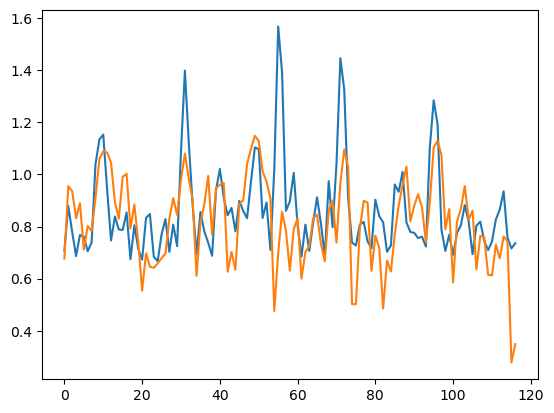

In [71]:
tr = out_ds.o.sel(split='val').isel(i=0).quantile(.99,dim='time')
plt.plot(out_ds.o.sel(split='val').where(out_ds.o.sel(split='val')>tr,drop=True).isel(i=0).values)
plt.plot(out_ds.yhat.sel(split='val').where(out_ds.o.sel(split='val')>tr,drop=True).isel(i=0).values)
np.corrcoef(out_ds.o.sel(split='val').where(out_ds.o.sel(split='val')>tr,drop=True).isel(i=0).values,out_ds.yhat.sel(split='val').where(out_ds.o.sel(split='val')>tr,drop=True).isel(i=0).values)

array([[1.        , 0.52257683],
       [0.52257683, 1.        ]])

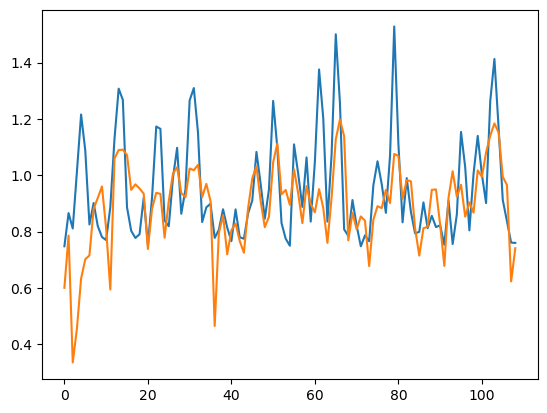

In [72]:
tr = out_ds.o.sel(split='test').isel(i=0).quantile(.99,dim='time')
plt.plot(out_ds.o.sel(split='test').where(out_ds.o.sel(split='test')>tr,drop=True).isel(i=0).values)
plt.plot(out_ds.yhat.sel(split='test').where(out_ds.o.sel(split='test')>tr,drop=True).isel(i=0).values)
np.corrcoef(out_ds.o.sel(split='test').where(out_ds.o.sel(split='test')>tr,drop=True).isel(i=0).values,out_ds.yhat.sel(split='test').where(out_ds.o.sel(split='test')>tr,drop=True).isel(i=0).values)

In [35]:
np.exp(3/.5)

403.4287934927351

In [8]:
predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands',tg)

In [11]:
predictand

,surge,date,lon,lat,shifted_year
13148,0.250125,1980-01-01 00:00:00,4.74499,52.964357,1980
13149,0.292063,1980-01-01 06:00:00,4.74499,52.964357,1980
13150,0.313682,1980-01-01 12:00:00,4.74499,52.964357,1980
13151,0.391755,1980-01-01 18:00:00,4.74499,52.964357,1980
13152,0.351097,1980-01-02 00:00:00,4.74499,52.964357,1980
...,...,...,...,...,...
65739,-0.697692,2015-12-30 18:00:00,4.74499,52.964357,2016
65740,-0.414111,2015-12-31 00:00:00,4.74499,52.964357,2016
65741,0.088533,2015-12-31 06:00:00,4.74499,52.964357,2016
65742,0.377569,2015-12-31 12:00:00,4.74499,52.964357,2016


In [5]:
ds = xr.open_mfdataset(os.path.join(output_dir,'exp_t_tests')+'/*barc*',concat_dim='t',combine='nested').load()

In [20]:
ds = xr.open_mfdataset(os.path.join(output_dir,'dl_alpha_tests_v2')+'/*held*mse*',concat_dim='a',combine='nested').load()

In [11]:
ds.rmse_extremes.isel(quantile=1)

<xarray.DataArray 'rmse_extremes' (a: 4, i: 1, split: 3)>
array([[[0.15359038, 0.19947298, 0.16634626]],

       [[0.15965703, 0.19288022, 0.17034356]],

       [[0.12997107, 0.17904966, 0.15136263]],

       [[0.14827616, 0.19125899, 0.16338632]]])
Coordinates:
  * split     (split) object 'train' 'val' 'test'
    quantile  float64 0.98
Dimensions without coordinates: a, i

In [15]:
qnts=[.95,.98,.99]
o_dmax = ds.o.resample(time='1D').max(skipna=True)
yhat_dmax = ds.yhat.resample(time='1D').max(skipna=True)
test = np.sqrt((( o_dmax.where(o_dmax>=o_dmax.quantile(qnts,dim='time'))-yhat_dmax.where(o_dmax>=o_dmax.quantile(qnts,dim='time')))**2 ).mean(dim='time'))
test.isel(quantile=1)


<xarray.DataArray (a: 14, i: 1, split: 3)>
array([[[0.09331205, 0.07492809, 0.05841244]],

       [[0.0806851 , 0.05769965, 0.05283703]],

       [[0.06485348, 0.054656  , 0.04678215]],

       [[0.06382443, 0.05156292, 0.04451104]],

       [[0.06898685, 0.04798609, 0.04448302]],

       [[0.07094738, 0.04972035, 0.04282005]],

       [[0.04953086, 0.04686133, 0.04848344]],

       [[0.05851833, 0.04251133, 0.04119786]],

       [[0.06619258, 0.039138  , 0.03825069]],

       [[0.06978688, 0.0435625 , 0.04032533]],

       [[0.0701599 , 0.04224859, 0.03846391]],

       [[0.06111094, 0.03780345, 0.03821661]],

       [[0.06657289, 0.03994721, 0.04063856]],

       [[0.06515761, 0.03752767, 0.04116144]]])
Coordinates:
  * split     (split) object 'train' 'val' 'test'
    quantile  float64 0.98
Dimensions without coordinates: a, i

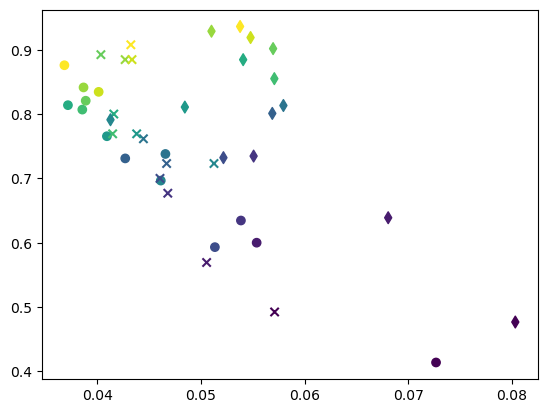

In [14]:
plt.figure()
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=0),ds.sel(split='val').isel(i=0).f1.isel(quantile=0))
plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=1),ds.sel(split='val').isel(i=0).recall.isel(quantile=1),c=ds.a)
plt.scatter(ds.sel(split='test').isel(i=0).rmse_extremes.isel(quantile=1),ds.sel(split='test').isel(i=0).recall.isel(quantile=1),c=ds.a,marker='x')
plt.scatter(ds.sel(split='train').isel(i=0).rmse_extremes.isel(quantile=1),ds.sel(split='train').isel(i=0).recall.isel(quantile=1),c=ds.a,marker='d')
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=2),ds.sel(split='val').isel(i=0).f1.isel(quantile=2))

In [21]:
ds.isel(i=0).rmse_extremes.isel(quantile=1)

<xarray.DataArray 'rmse_extremes' (a: 14, split: 3)>
array([[0.16191544, 0.22780465, 0.18018051],
       [0.17679437, 0.21778942, 0.19327579],
       [0.13983315, 0.20670051, 0.17689905],
       [0.15850801, 0.19480325, 0.17133223],
       [0.19530527, 0.20757753, 0.20183619],
       [0.14025106, 0.19170952, 0.1634773 ],
       [0.13313877, 0.18896673, 0.16189138],
       [0.12990468, 0.17563057, 0.15073411],
       [0.14933763, 0.18098688, 0.15946259],
       [0.12118854, 0.17873512, 0.14536096],
       [0.13517853, 0.17738494, 0.1525298 ],
       [0.14471015, 0.18138227, 0.15858956],
       [0.14113134, 0.17815194, 0.15981767],
       [0.12746947, 0.17219284, 0.15621797]])
Coordinates:
  * split     (split) object 'train' 'val' 'test'
    quantile  float64 0.98
Dimensions without coordinates: a

In [23]:
ds.r_extremes.sel(split='test')

<xarray.DataArray 'r_extremes' (a: 14, i: 1, quantile: 3)>
array([[[0.80284322, 0.74670626, 0.6812783 ]],

       [[0.7772784 , 0.71767587, 0.64136181]],

       [[0.80120311, 0.76554247, 0.71816959]],

       [[0.77138872, 0.72724957, 0.67407967]],

       [[0.73723062, 0.70403388, 0.66153774]],

       [[0.76154411, 0.73309103, 0.67815695]],

       [[0.79436568, 0.76099304, 0.69869776]],

       [[0.78789298, 0.76598767, 0.70475691]],

       [[0.75282419, 0.73426145, 0.69162905]],

       [[0.7920554 , 0.78470757, 0.76283817]],

       [[0.74017251, 0.72189791, 0.66736333]],

       [[0.71035228, 0.6758648 , 0.59719618]],

       [[0.68962234, 0.66967724, 0.57003603]],

       [[0.72470402, 0.7146356 , 0.69403045]]])
Coordinates:
    split     <U4 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: a, i

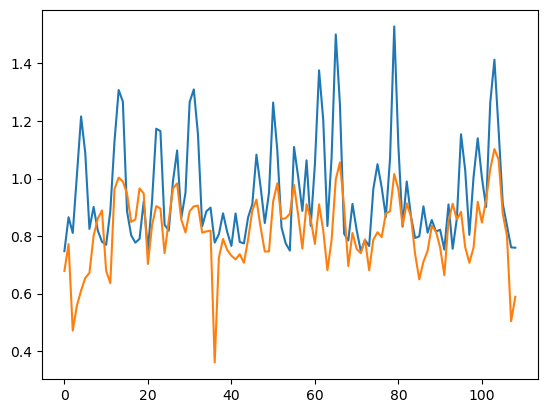

In [25]:
plt.figure()
plt.plot(ds.o.sel(split='test').isel(i=0,a=-2).where(ds.o.sel(split='test').isel(i=0,a=-2)>ds.o.sel(split='test').isel(i=0,a=-2).quantile(.99,dim='time'),drop=True).values)
plt.plot(ds.yhat.sel(split='test').isel(i=0,a=-2).where(ds.o.sel(split='test').isel(i=0,a=-2)>ds.o.sel(split='test').isel(i=0,a=-2).quantile(.99,dim='time'),drop=True).values)



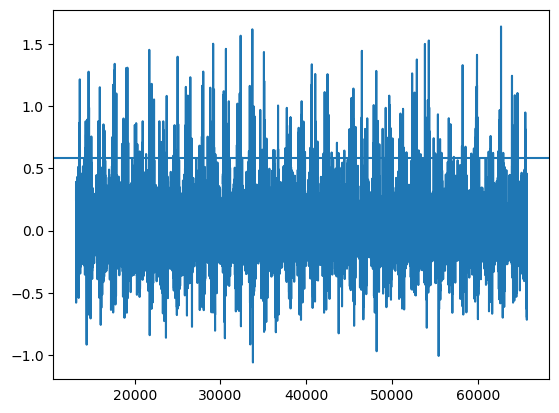

In [127]:
predictand.surge.plot()
plt.axhline(y=np.nanpercentile(predictand.surge,98))

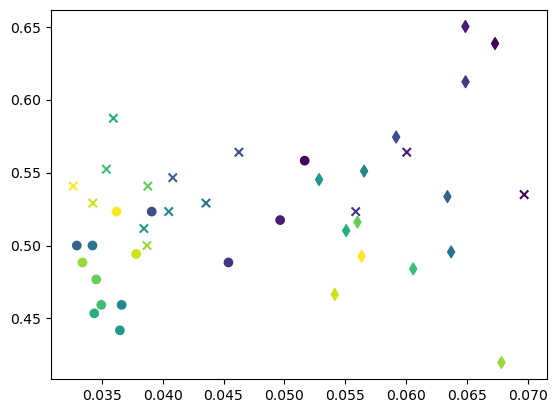

In [63]:
qnts = [.95,.98,.99]
tp_self = (((ds.o>=ds.o.quantile(qnts,dim='time'))) & (ds.yhat>=ds.yhat.quantile(qnts,dim='time'))).where(np.isfinite(ds.o)).sum(dim='time')
fp_self = (((ds.o>=ds.o.quantile(qnts,dim='time'))==False) & (ds.yhat>=ds.yhat.quantile(qnts,dim='time'))).where(np.isfinite(ds.o)).sum(dim='time')
precision_self = tp_self/(tp_self+fp_self)
plt.figure()
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=0),ds.sel(split='val').isel(i=0).f1.isel(quantile=0))
plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=1),precision_self.sel(split='val').isel(i=0).isel(quantile=1),c=ds.alpha)
plt.scatter(ds.sel(split='test').isel(i=0).rmse_extremes.isel(quantile=1),precision_self.sel(split='test').isel(i=0).isel(quantile=1),c=ds.alpha,marker='x')
plt.scatter(ds.sel(split='train').isel(i=0).rmse_extremes.isel(quantile=1),precision_self.sel(split='train').isel(i=0).isel(quantile=1),c=ds.alpha,marker='d')
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=2),ds.sel(split='val').isel(i=0).f1.isel(quantile=2))

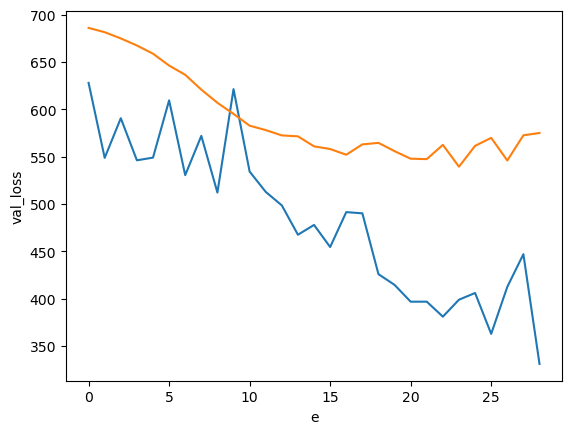

In [57]:
out_ds.loss.isel(i=0).plot()
out_ds.val_loss.isel(i=0).plot()

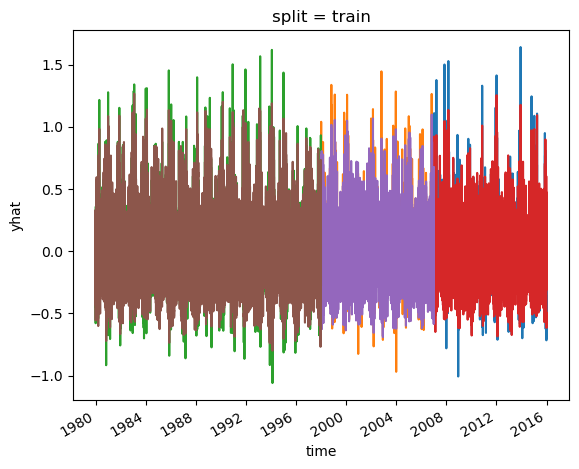

In [7]:
out_ds.o.sel(split='test').plot()
out_ds.o.sel(split='val').plot()
out_ds.o.sel(split='train').plot()

out_ds.yhat.sel(split='test').plot()
out_ds.yhat.sel(split='val').plot()
out_ds.yhat.sel(split='train').plot()

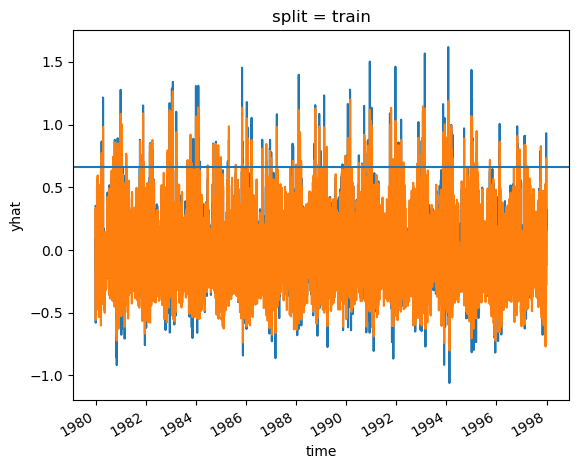

In [8]:
plt.figure()
#out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

#out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='train').isel(i=0).plot()
out_ds.yhat.sel(split='train').isel(i=0).plot()
plt.axhline(y=out_ds.yhat.sel(split='train').isel(i=0).quantile(.98,dim='time').values)

(-2.0, 2.0)

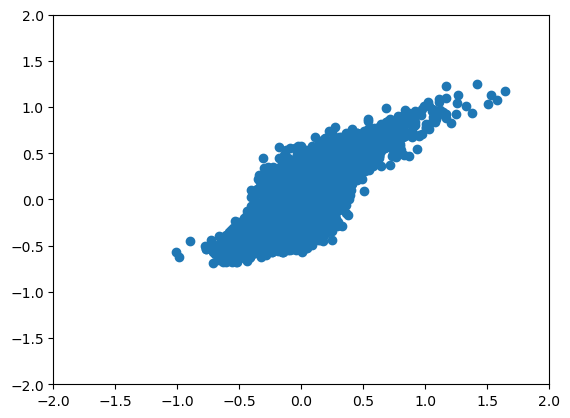

In [9]:
plt.scatter(out_ds.o.sel(split='test').isel(i=0),out_ds.yhat.sel(split='test').isel(i=0))
plt.ylim([-2,2])
plt.xlim([-2,2])

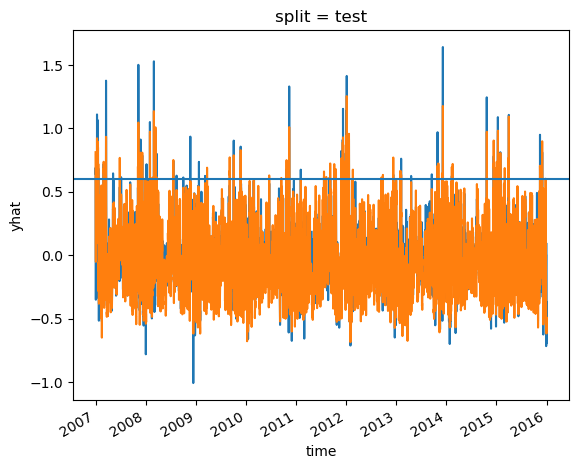

In [ ]:
plt.figure()
#out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

#out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='test').isel(i=0).plot()
out_ds.yhat.sel(split='test').isel(i=0).plot()
plt.axhline(y=out_ds.yhat.sel(split='test').isel(i=0).quantile(.98,dim='time').values)

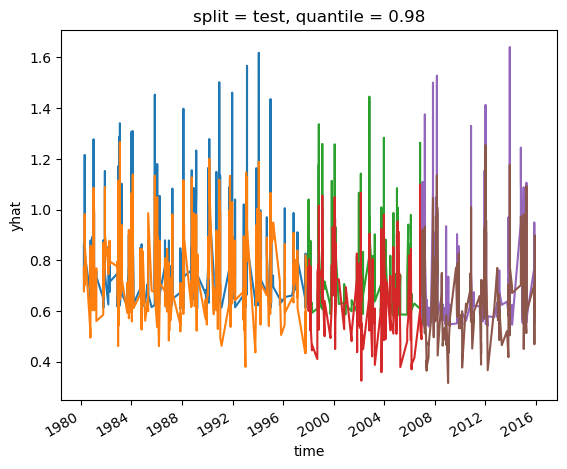

In [ ]:
plt.figure()
out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).plot()


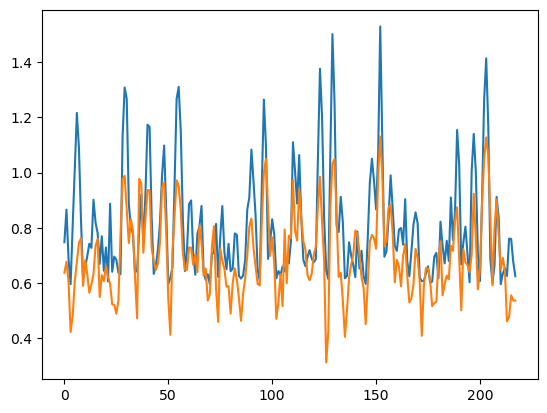

In [18]:
plt.figure()
plt.plot(out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).values)
plt.plot(out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).values)


In [17]:
out_ds.rmse_extremes.sel(split='test')

<xarray.DataArray 'rmse_extremes' (i: 1, quantile: 3)>
array([[0.13046875, 0.14627086, 0.17575544]])
Coordinates:
    split     <U5 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

In [18]:
out_ds.r_extremes.sel(split='test')

<xarray.DataArray 'r_extremes' (i: 1, quantile: 3)>
array([[0.76944061, 0.76073639, 0.72139865]])
Coordinates:
    split     <U5 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

In [16]:
threshold_pct=99
threshold_value = ds.o.isel(i=0).isel(a=0).sel(split='test').quantile(.99,dim='time').values

y_true = ds.o.isel(i=0).isel(a=0).sel(split='test')#.resample(time='1D')#.dropna(dim='time')

surge_codec = xr.open_dataset('/home/jovyan/test_surge_models/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc')
surge_codec = surge_codec.sel(tg='den_helder-denhdr-nld-rws.csv').sel(time=ds.time.where(np.isfinite(y_true),drop=True))

surge_codec['surge'] = surge_codec['surge'].rolling(time=3,min_periods=1,center=True).mean()
surge_codec = surge_codec#.resample(time='1D').max(skipna=True)
#surge_codec['surge'] = (surge_codec['surge'] - surge_codec['surge'].mean(dim='time'))/surge_codec['surge'].std(dim='time',ddof=0) #normalize
#surge_codec_test=surge_codec.surge.values[np.isfinite(y_true)]
#y_true = y_true[np.isfinite(y_true)]
y_true = ds.o.isel(i=0).isel(a=0).sel(split='test')#.resample(time='1D').max(skipna=True)
y_true = y_true.values[np.isfinite(y_true)]
#surge_codec_test = surge_codec.sel(tg=tg).sel(time=predictand['date'].values[idx_test][n_steps-1::]).surge.values #select test timesteps
surge_codec_test_exceedances = (surge_codec.surge.values>=threshold_value).flatten() #find where exceeding threshold
y_true_exceedances = (y_true>=threshold_value)
print('---CoDEC---')
print('bulk correlation r='+str(np.corrcoef(surge_codec.surge.values,y_true)[0][1]))
print('bulk RMSE='+str(rmse(surge_codec.surge.values,y_true)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(y_true_exceedances,surge_codec_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])))


---CoDEC---
bulk correlation r=0.917464025827296
bulk RMSE=0.09566347785229094
Confusion matrix exceedances above 99th percentile:
[[10753    38]
 [   13    96]]
Correlation at timesteps where observations above 99th percentile:
r=0.8074886176537865
RMSE at timesteps where observations above 99th percentile:
RMSE=0.11380775293214636


In [44]:
surge_codec = xr.open_dataset('/home/jovyan/test_surge_models/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc')
surge_codec = surge_codec.sel(tg='den_helder-denhdr-nld-rws.csv').sel(time=ds.time.where(np.isfinite(y_true),drop=True))

TypeError: cond argument is array([ True,  True,  True, ...,  True,  True,  True]) but must be a <class 'xarray.core.dataset.Dataset'> or <class 'xarray.core.dataarray.DataArray'>

In [43]:
ds.o.isel(i=0).isel(a=0).sel(split='test').resample(time='1D').max(skipna=True).where(np.isfinite(ds.o.isel(i=0).isel(a=0).sel(split='test').resample(time='1D').max(skipna=True)),drop=True)

<xarray.DataArray 'o' (time: 3287)>
array([ 0.68951166,  0.57177655, -0.035822  , ..., -0.36468246,
       -0.39053456,  0.08853344])
Coordinates:
    split    <U4 'test'
  * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2015-12-31

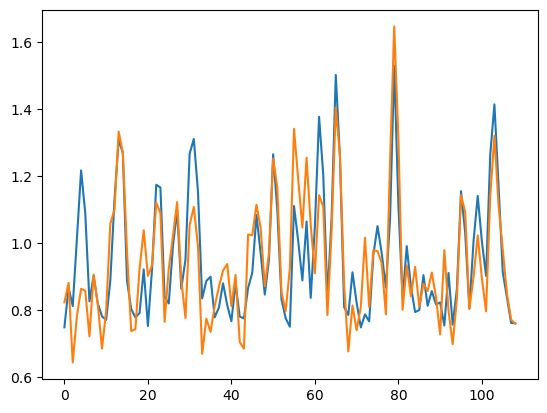

In [17]:

plt.plot(y_true[y_true_exceedances])
plt.plot(surge_codec.surge.values[y_true_exceedances])

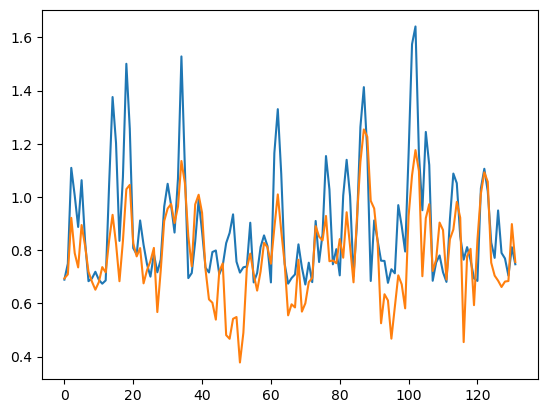

In [23]:
plt.plot(out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.99,dim='time'),drop=True).values)
plt.plot(out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.99,dim='time'),drop=True).values)


In [20]:
out_ds.r_bulk

<xarray.DataArray 'r_bulk' (i: 1, split: 3)>
array([[0.70603564, 0.67384388, 0.6716272 ]])
Coordinates:
  * split    (split) <U5 'train' 'val' 'test'
Dimensions without coordinates: i

In [21]:
out_ds.o.quantile(.99,dim='time')

<xarray.DataArray 'o' (i: 1, split: 3)>
array([[0.2005901 , 0.20513289, 0.20433226]])
Coordinates:
  * split     (split) <U5 'train' 'val' 'test'
    quantile  float64 0.99
Dimensions without coordinates: i

Tensorflow pipeline:

```python
#get values & timestamps of observations to compare predictions with
o_val = y_train_sd * y_val[np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split
o_test = y_train_sd * y_test[np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split

t_val = predictand['date'].values[idx_val][np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)]
t_test = predictand['date'].values[idx_test][np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)]

#create windowed predictors, filter out timesteps with NaN observations & create batches:
if use_dl == False: #if not using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size).cache() #cache() speeds up the training by loading in the data at epoch 0, but takes up a lot of memory
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size).cache()

    x_val_ds = z_val.map(lambda a, b : a) #unpack z_val for prediction

elif use_dl == True: #if using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size, w_train).cache()
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size, w_val).cache()

    x_val_ds = z_val.map(lambda a, b, c: a) #unpack z_val for prediction

z_test = create_batched_sequenced_datasets(x_test, y_test, this_n_steps, this_batch_size) #to-do: z_test doesn't have to be batched?
x_test_ds = z_test.map(lambda a, b: a) #unpack z_test for prediction

history = model.fit(z_train,epochs=n_epochs,validation_data=z_val,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                            restore_best_weights=True)],verbose=0) #train model
            
#make predictions & back-transform
yhat_val = model.predict(x_val_ds,verbose=0).flatten()*y_train_sd + y_train_mean
yhat_test = model.predict(x_test_ds,verbose=0).flatten()*y_train_sd + y_train_mean
```